In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

In [48]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 6),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()
    
    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df['date'], y=df['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['20 Day MA'], mode='lines', line=dict(dash='dash'), name='20 Day MA'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Lower Band'], mode='lines', line=dict(dash='dash'), name='Lower Band'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Upper Band'], mode='lines', line=dict(dash='dash'), name='Upper Band', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        
        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(True, alpha=0.5)
    
        ax.plot(df['date'], df['close'], label='Daily Close Price')
        ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
        ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
        ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
        ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands
    
        ax.set_title('Daily stock price for ' + stock_name.upper())
        ax.legend()
    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 513.07
Latest 20 Day MA: 517.3050003051758
Latest Lower Bollinger Band: 508.93137817874197
Latest Higher Bollinger Band: 525.6786224316096


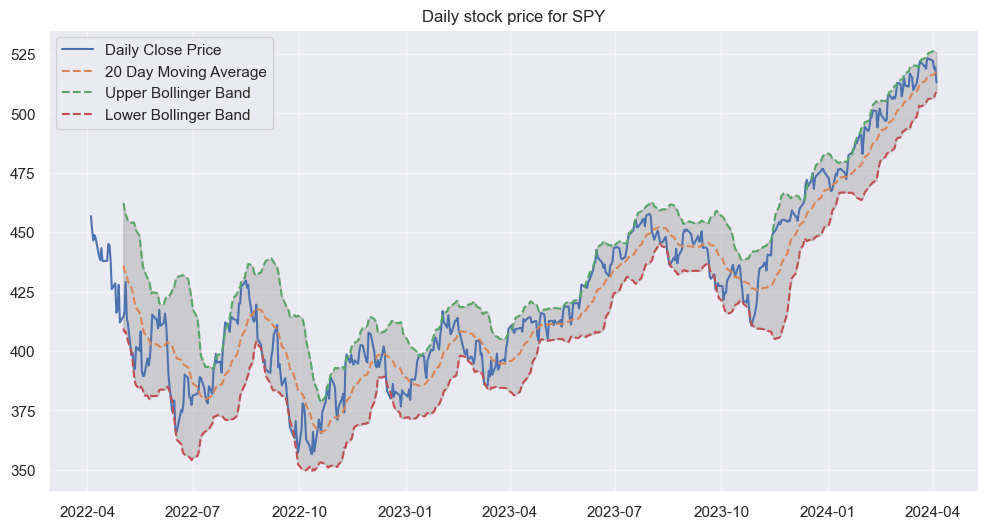

In [49]:
plot_stock('spy')

[*********************100%%**********************]  1 of 1 completed
high - open 95% confidence value: 0.011515689000490428
low - open 95% confidence value: -0.01176717282714377
close - open 95% confidence values - two-tail: -0.01101932711825098 0.01122305733122807


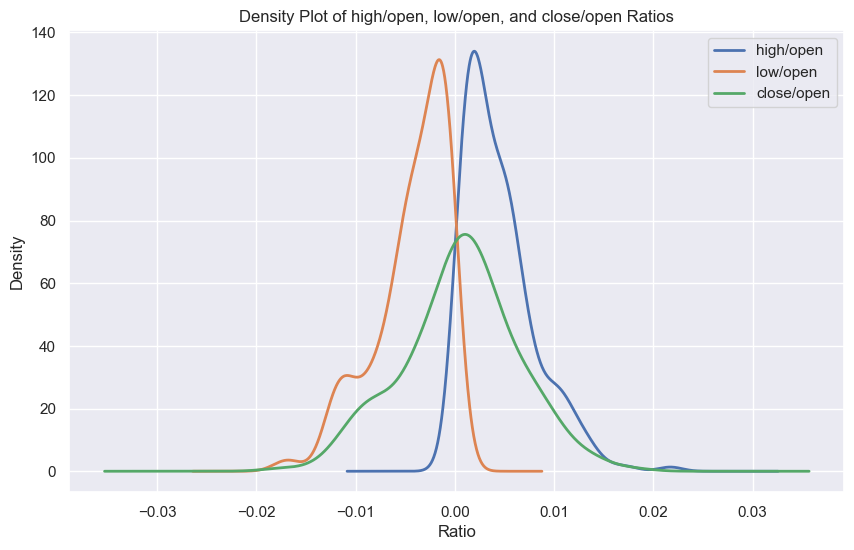

In [46]:
# SPY daily price range
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                     end=datetime.today().strftime('%Y-%m-%d'))
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()

print('high - open 95% confidence value:', ((df_spy['high']-df_spy['open'])/df_spy['open']).quantile(q=0.95))
print('low - open 95% confidence value:',((df_spy['low']-df_spy['open'])/df_spy['open']).quantile(q=0.05))
print('close - open 95% confidence values - two-tail:',((df_spy['close']-df_spy['open'])/df_spy['open']).quantile(q=0.025), ((df_spy['close']-df_spy['open'])/df_spy['open']).quantile(q=0.975))



plt.figure(figsize=(10, 6))
# Density plot for high_open_ratio
((df_spy['high']-df_spy['open'])/df_spy['open']).plot(kind='density', label='high/open', linewidth=2)

# Density plot for low_open_ratio
((df_spy['low']-df_spy['open'])/df_spy['open']).plot(kind='density', label='low/open', linewidth=2)

# Density plot for close_open_ratio
((df_spy['close']-df_spy['open'])/df_spy['open']).plot(kind='density', label='close/open', linewidth=2)

plt.xlabel('Ratio')
plt.ylabel('Density')
plt.title('Density Plot of high/open, low/open, and close/open Ratios')
plt.legend()
plt.show()


In [47]:
df=df_spy
df['Close_Open_ratio'] = (df['close'] - df['open']) / df['open']

# Calculate mean and standard error
mean = df['Close_Open_ratio'].mean()
std = df['Close_Open_ratio'].std() 

print("95% Confidence Interval:", df['Close_Open_ratio'].mean()-1.96*df['Close_Open_ratio'].std(), df['Close_Open_ratio'].mean()+1.96*df['Close_Open_ratio'].std())

95% Confidence Interval: -0.010891058965811027 0.011993671091225566


In [12]:
df_spy = yf.download('spy'.upper(),
                     start=(datetime.today() - relativedelta(years=10)).strftime('%Y-%m-%d'),
                     end=datetime.today(),
                    )
df_spy = df_spy.reset_index()
df_spy.columns = df_spy.columns.str.lower()
print(df_spy.shape)
df_spy.head()

[*********************100%%**********************]  1 of 1 completed
(2517, 7)


,date,open,high,low,close,adj close,volume
0,2014-04-04,189.660004,189.699997,186.100006,186.399994,155.776245,169381000
1,2014-04-07,185.949997,186.259995,183.960007,184.339996,154.054657,140803000
2,2014-04-08,184.259995,185.399994,183.589996,185.100006,154.689880,112660000
3,2014-04-09,185.600006,187.149994,185.059998,187.089996,156.352890,100254000
4,2014-04-10,187.080002,187.169998,182.929993,183.160004,153.068558,172959000


In [50]:
# Generate synthetic daily stock price data for demonstration
np.random.seed(42)  # for reproducibility
num_days = df_spy.shape[0]  
initial_price = df_spy['close'][0]
drift = 0.05  # initial guess for drift
volatility = 0.2  # initial guess for volatility

# Generate synthetic daily stock price data
def generate_stock_prices(drift, volatility, initial_price, num_days):
    daily_returns = np.exp((drift - 0.5 * volatility**2) + volatility * norm.ppf(np.random.rand(num_days)))
    stock_prices = initial_price * pd.Series(daily_returns.cumprod(), name='Close')
    return stock_prices

# Log-likelihood function for GBM
def gbm_log_likelihood(params, prices):
    mu, sigma = params
    dt = 1  # time increment (1 day)
    returns = np.diff(np.log(prices))
    ll = -len(returns) / 2 * np.log(2 * np.pi) - len(returns) / 2 * np.log(sigma ** 2) - (1 / (2 * sigma ** 2)) * np.sum((returns - (mu - 0.5 * sigma ** 2) * dt) ** 2)
    return -ll

# Fit GBM parameters using MLE
def fit_gbm_params(prices):
    initial_guess = [0.05, 0.2]  # initial guess for drift and volatility
    result = minimize(gbm_log_likelihood, initial_guess, args=(prices,), bounds=((None, None), (0.001, None)))
    mu_mle, sigma_mle = result.x
    return mu_mle, sigma_mle

In [51]:
drift_mle, volatility_mle = fit_gbm_params(df_spy['close'])
print('Drift:', drift_mle)
print('Volatility:', volatility_mle)

Drift: 0.0004579561887733856
Volatility: 0.011112987077973938


In [52]:
estimated_prices = generate_stock_prices(drift_mle, volatility_mle, initial_price, num_days)
estimated_prices

0       183.659037
1       187.135664
2       188.501763
3       189.100844
4       187.062335
           ...    
2511    487.770490
2512    487.259830
2513    487.594619
2514    489.541044
2515    497.686979
Name: Close, Length: 2516, dtype: float64

In [53]:
expectation_return = initial_price*np.exp(drift_mle*np.arange(start=0, stop=num_days))
expectation_return

array([184.24000549, 184.32439867, 184.4088305 , ..., 582.35672395,
       582.62347889, 582.89035602])

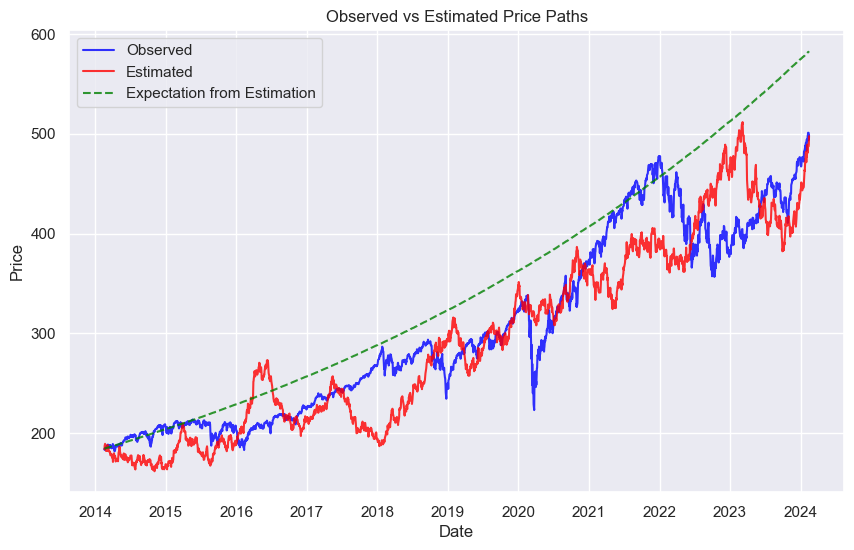

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(df_spy['date'], df_spy['close'], label='Observed', color='blue', alpha=0.8)
plt.plot(df_spy['date'], estimated_prices.values, label='Estimated', color='red', alpha=0.8)
plt.plot(df_spy['date'], expectation_return, label='Expectation from Estimation', color='green',linestyle='--', alpha=0.8)

plt.title('Observed vs Estimated Price Paths')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()